## Import required Library

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numba import jit, jitclass, roc
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import ipywidgets as widgets

import optimization as optim
from utils import update, update_backtrack, update_gd
from metrics import mse_loss, r2_scoring, adjusted_r2

np.random.seed(1234)
%matplotlib inline

## Import raw data

In [28]:
raw_data = pd.read_csv("../kc_house_data.csv")
raw_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


## 1. Preprocessing raw data

In [3]:
#getting to know about the datatypes
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  int64  
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  int64  
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Checking for Null value
print("Have {} Null value".format(sum(raw_data.isnull().sum())))

Have 0 Null value


In [5]:
#find the mean, count, min, max, percentile, standard deviation of given data
raw_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


#### 1.1 Corr. matrix

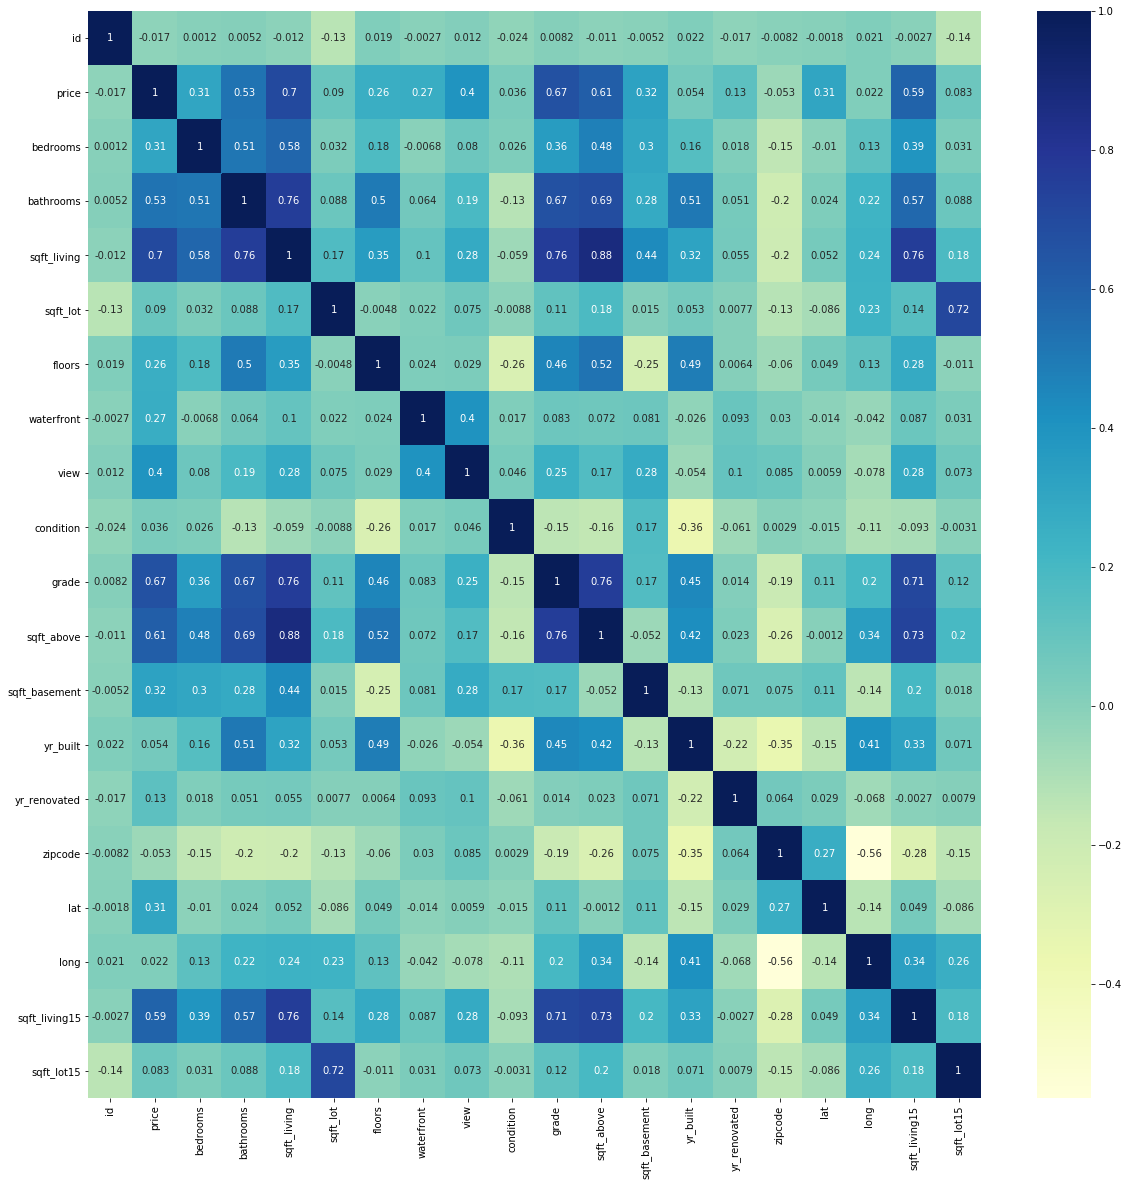

In [6]:
raw_data.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(raw_data.corr(),cmap = 'YlGnBu',annot=True,ax=ax)

#### 1.2 Select data with high correlated features (> 0.5)

In [29]:
features = raw_data.corr()
features = features[features.price>0.5]
features = list(features.index)
print(features)
data = raw_data[features]

['price', 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15']


#### 1.3 QQPlot to check linear of target variable

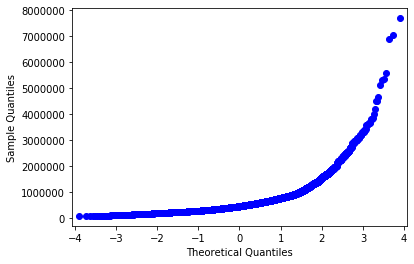

In [8]:
sm.qqplot(data['price'])
plt.show()

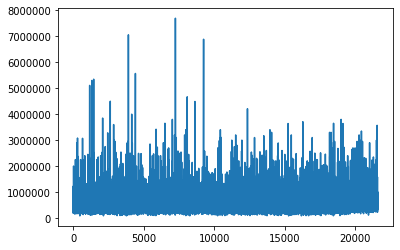

In [9]:
plt.plot(data['price'])

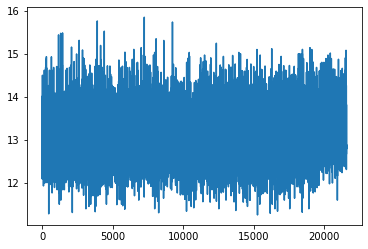

In [10]:
plt.plot(np.log(data['price']))

#### 1.4 Pairplot to check collinarity

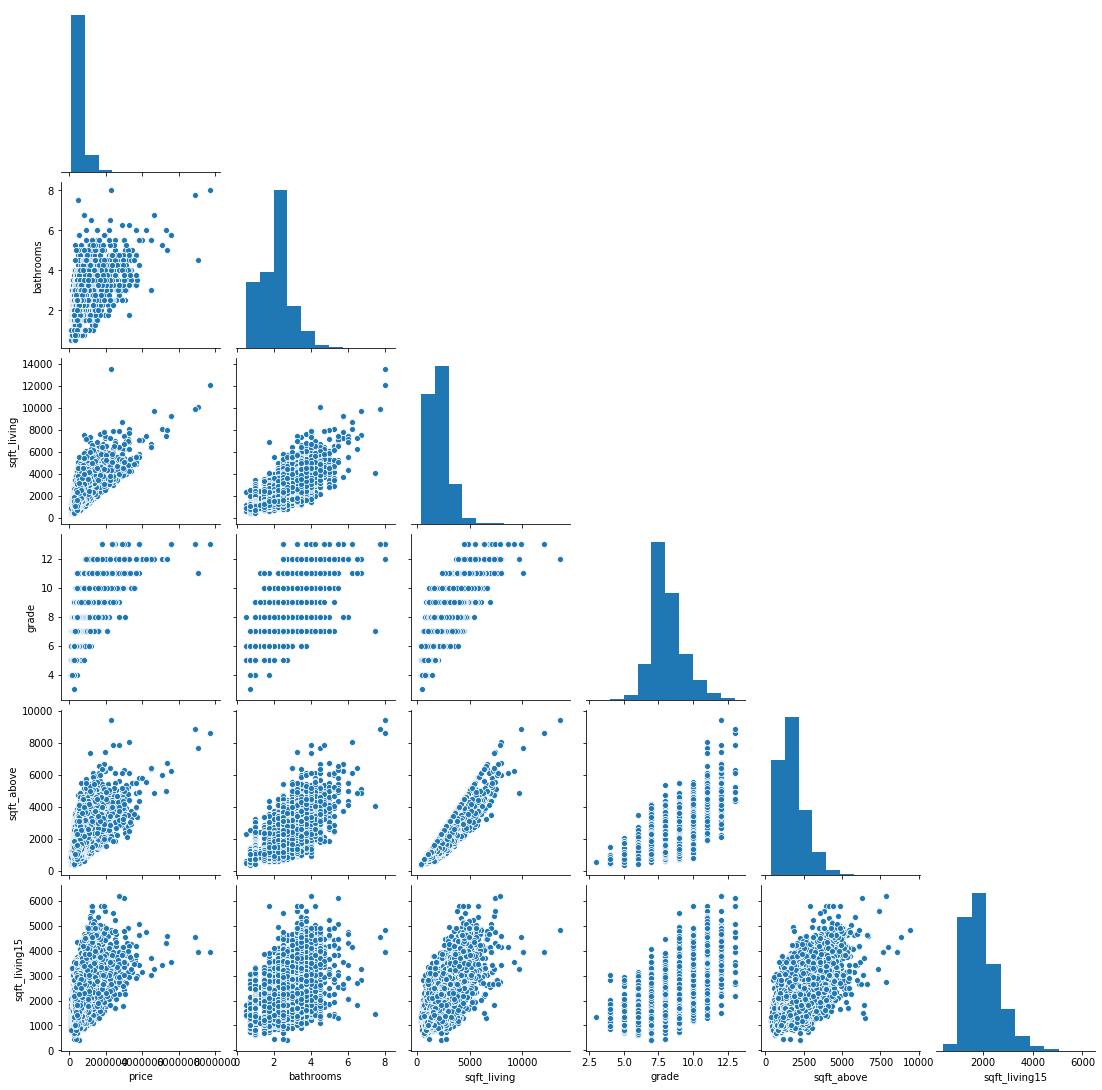

In [11]:
 sns.pairplot(data, corner=True)

#### 1.5 Calculte VIF to check multicollinearity

In [12]:
data_tmp = sm.add_constant(data)
vifs = [vif(data_tmp.values, i) for i in range(data_tmp.shape[1])]
pd.Series(data=vifs, index=data_tmp.columns) # .sort_values(ascending=False)

const            71.491364
price             2.195101
bathrooms         2.470160
sqft_living       6.894604
grade             3.231138
sqft_above        4.854692
sqft_living15     2.684953
dtype: float64

#### 1.6 Pre-processing

In [30]:
X = data.drop("price", axis=1)
Y = data["price"]
# Log transform
Y_log = np.log(Y)
# Split to train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_log, test_size=0.20)
# Scaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## 2. Train model with Library Linear Regression (testing)

In [10]:
model = LinearRegression()
model.fit(X_train, Y_train)
# Predicted value
Y_pred = model.predict(scaler.transform(X_test))
# Measure regression performance
r2score = r2_score(Y_test, Y_pred)
adj_r2 = 1 - ((1-r2score)*(len(X_test)-1) / (len(X_test)-5-1))

print("MSE :", np.mean(np.square(Y_pred - Y_test)))
print('R2 :',r2score)
print('Adjusted R2:', adj_r2)

MSE : 0.11461622204507492
R2 : 0.5807097028485364
Adjusted R2: 0.5802237382018611


## 3. Normal equation (testing)

In [31]:
# Transform DataFrame to ndarray
x = np.hstack((np.ones((len(X_train), 1)), X_train))
y = Y_train.values.reshape(-1, 1)

x_test = np.hstack((np.ones((len(X_test), 1)), scaler.transform(X_test)))
y_test = Y_test.values.reshape(-1, 1)

In [32]:
theta = optim.normal_equation(x, y)
y_pred = x_test.dot(theta)
y_mean = np.mean(y)
f = lambda y1, y2: np.sum(np.square(y1 - y2))

print("MSE :", mse_loss(x_test, y_test, theta))
print("R2 :",r2_scoring(x_test, y_test, theta))
print("Adjusted :", adjusted_r2(x_test, y_test, theta))

MSE : 0.11461622204507486
R2 : 0.5807097028485366
Adjusted : 0.5802237382018613


## 4. GD based optimization

In [16]:
w, _ = update(x, y, 'adam', 1, 0.1, keep_remainder=True, debug=False)
print("Loss's test phase :", mse_loss(x_test, y_test, w))
print("R2 :",r2_scoring(x_test, y_test, w))
print("Adjusted :",adjusted_r2(x_test, y_test, w))

Converge after 0.9625s at epoch 1 --- batch 16756/17277 --- loss (training) 0.0034938739003669366
Loss's test phase : 0.16566178827681546
R2 : 0.39397426303309635
Adjusted : 0.39327186880851717


## 5. Plot

### 5.1 Compare Line search & BGD

In [22]:
# Handler for backtrack plot
def alpha_eventhandler(change):
    '''Event handler for alpha slider
    '''
    out_1.clear_output()
    with out_1:
        fig, ax = plt.subplots(constrained_layout=True)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.grid(True)
        _, loss_history = update_backtrack(x, y,
                                           change.new,
                                           beta_slider.value,
                                           False)
        ax = plt.plot(loss_history)
        plt.show()

def beta_eventhandler(change):
    '''Event handler for beta slider
    '''
    out_1.clear_output()
    with out_1:
        fig, ax = plt.subplots(constrained_layout=True)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.grid(True)
        _, loss_history = update_backtrack(x, y,
                                           alpha_slider.value,
                                           change.new,
                                           False)
        ax = plt.plot(loss_history)
        plt.show()

def lr_eventhandler(change):
    '''Event handler for lr slider
    '''
    out_2.clear_output()
    with out_2:
        fig, ax = plt.subplots(constrained_layout=True)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.grid(True)
        _, loss_history = update_gd(x, y, change.new, False)
        ax = plt.plot(loss_history)
        plt.show()

In [23]:
out_1 = widgets.Output()

alpha_slider = widgets.FloatSlider(value=.5,
                                   min=0.,
                                   max=0.5,
                                   step=0.01,
                                   description='Alpha value :',
                                   disabled=False,
                                   continuous_update=True,
                                   orientation='horizontal',
                                   readout=True,
                                   readout_format='.2f',)

beta_slider = widgets.FloatSlider(value=.5,
                                   min=0.1,
                                   max=0.9,
                                   step=0.1,
                                   description='Beta value :',
                                   disabled=False,
                                   continuous_update=True,
                                   orientation='horizontal',
                                   readout=True,
                                   readout_format='.2f',)


alpha_slider.observe(alpha_eventhandler, names='value')
beta_slider.observe(beta_eventhandler, names='value')

control_config_1 = widgets.VBox([widgets.Label(value="CONFIG PANEL (BACKTRACK)", layout=widgets.Layout(left='80px')),
                               alpha_slider,
                               beta_slider,]
                             )

In [24]:
out_2 = widgets.Output()

lr_slider = widgets.FloatSlider(value=.25,
                                min=0,
                                max=0.5,
                                step=0.01,
                                description='Lr_rate :',
                                disabled=False,
                                continuous_update=True,
                                orientation='horizontal',
                                readout=True,
                                readout_format='.3f',)

lr_slider.observe(lr_eventhandler, names='value')
control_config_2 = widgets.VBox([widgets.Label(value="CONFIG PANEL (BGD)", layout=widgets.Layout(left='80px')),
                               lr_slider,]
                             )

In [25]:
app = widgets.TwoByTwoLayout(top_left=control_config_1,
                             top_right=out_1,
                             bottom_left=control_config_2,
                             bottom_right=out_2)

In [26]:
app

TwoByTwoLayout(children=(VBox(children=(Label(value='CONFIG PANEL (BACKTRACK)', layout=Layout(left='80px')), F…

### 5.2 (Optinal)

In [23]:
def lr_eventhandler(change):
    '''Event handler for learning rate slider
    '''
    out_.clear_output()
    with out_:
        fig, ax = plt.subplots(constrained_layout=True)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.grid(True)
        _, loss_history = update(x, y, algo_slider.value,
                                 bs_text.value,
                                 change.new,
                                 remain_checkbox.value,
                                 False)
        ax = plt.plot(loss_history)
        plt.show()

def algo_eventhandler(change):
    '''Event handler for algorithm slider
    '''
    out_.clear_output()
    with out_:
        fig, ax = plt.subplots(constrained_layout=True)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.grid(True)
        _, loss_history = update(x, y, change.new,
                                 bs_text.value,
                                 lr_slider.value,
                                 remain_checkbox.value,
                                 False)
        ax = plt.plot(loss_history)
        plt.show()

def bs_eventhandler(change):
    '''Event handler for batch size text
    '''
    out_.clear_output()
    with out_:
        fig, ax = plt.subplots(constrained_layout=True)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.grid(True)
        _, loss_history = update(x, y, algo_slider.value,
                                 change.new,
                                 lr_slider.value,
                                 remain_checkbox.value,
                                 False)
        ax = plt.plot(loss_history)
        plt.show()

def rc_eventhandler(change):
    '''Event handler for batch size text
    '''
    out_.clear_output()
    with out_:
        fig, ax = plt.subplots(constrained_layout=True)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.grid(True)
        _, loss_history = update(x, y, algo_slider.value,
                                 bs_text.value,
                                 lr_slider.value,
                                 change.new,
                                 False)
        ax = plt.plot(loss_history)
        plt.show()

In [24]:
out_ = widgets.Output(layout=widgets.Layout(left='200px'))

algo_slider = widgets.Dropdown(options=[('Backtracking Line search', 'line_search'),
                                        ('Stochastic Gradient Descent', 'sgd'),
                                        ('Momentum SGD', 'momentum_sgd'),
                                        ('AdaGrad', 'adagrad'),
                                        ('RMSProp', 'rmsprop'),
                                        ('Adam', 'adam')],
                               value='sgd',
                               description='Algorithm :',)

lr_slider = widgets.FloatSlider(value=.25,
                                min=0,
                                max=0.5,
                                step=0.01,
                                description='Lr_rate :',
                                disabled=False,
                                continuous_update=True,
                                orientation='horizontal',
                                readout=True,
                                readout_format='.3f',)

bs_text = widgets.BoundedIntText(value=len(x),
                                 min=1, max=len(x),
                                 step=1,
                                 description='Batch size:',
                                 disabled=False)

remain_checkbox = widgets.Checkbox(value=False,
                                   description='Keep remain or Not',
                                   disabled=False,
                                   indent=False,
                                   layout=widgets.Layout(left='80px'))

algo_slider.observe(algo_eventhandler, names='value')
lr_slider.observe(lr_eventhandler, names='value')
bs_text.observe(bs_eventhandler, names='value')
remain_checkbox.observe(rc_eventhandler, names='value')

control_config = widgets.VBox([widgets.Label(value="CONFIG PANEL", layout=widgets.Layout(left='80px')),
                               algo_slider,
                               bs_text,
                               lr_slider,
                               remain_checkbox])

display(widgets.HBox([control_config, out_]))

###### Testing

In [48]:
def find_best_params(x, y, name):
    '''Find best learning rate/beta with specified algorithm
    Get losse with all lr_rate(or beta) value from 0 to .5 (step = 0.01)
    Outputs:
     - lr_rate/beta (scalar) : learning rate value that has the lowest loss
    '''
    all_loss = {}
    for i in np.arange(0., .5, 0.01):
        if name == 'sgd':
            _, loss = update_gd(x, y, i, False)
        if name == 'backtrack':
            _, loss = update_backtrack(x, y, 0.5, i, False)
        all_loss[i] = loss[-1]
    
    return [k for k in sorted(all_loss.items(), key=lambda item: abs(item[1] - loss_ne))][0][0]

#update(x, y, name, batch_size, lr_rate, keep_remainder=True, debug=None):
loss_ne = mse_loss(x_test, y_test, theta)
find_best_params(x, y, 'backtrack')

Converge at epoch 3 ---- Loss : 11.789432086274852
Converge at epoch 675 ---- Loss : 0.12069293518533823
Converge at epoch 216 ---- Loss : 0.12050197748099373
Converge at epoch 233 ---- Loss : 0.12052534690189919
Converge at epoch 86 ---- Loss : 0.12046323859945476
Converge at epoch 118 ---- Loss : 0.12047986546123189
Converge at epoch 82 ---- Loss : 0.12047576619695423
Converge at epoch 71 ---- Loss : 0.12047100811715147
Converge at epoch 103 ---- Loss : 0.12047310759823532
Converge at epoch 61 ---- Loss : 0.12046352810864977
Converge at epoch 99 ---- Loss : 0.12046335481964486
Converge at epoch 53 ---- Loss : 0.1204594266376954
Converge at epoch 67 ---- Loss : 0.12045962103556584
Converge at epoch 77 ---- Loss : 0.12045741261645843
Converge at epoch 80 ---- Loss : 0.12045769949834015
Converge at epoch 75 ---- Loss : 0.12045609208156526
Converge at epoch 71 ---- Loss : 0.12045299600500324
Converge at epoch 37 ---- Loss : 0.12044666995245987
Converge at epoch 50 ---- Loss : 0.120453039

0.31